In [1]:
from i10_bluesky.devices.rasor.detectorSlits import *
from i10_bluesky.devices.scalerCard import ScaleCard
from i10_bluesky.devices.pimteAD import *
from i10_bluesky.plans.rasor.pimte_plans import AdPlan
from ophyd_async.core import DeviceCollector 
from ophyd_async.core.detector import TriggerInfo, DetectorTrigger
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky import RunEngine
from bluesky.plans import count, scan  
import bluesky.plan_stubs
from ophyd.sim import det1
from bluesky import utils
from bluesky.utils import Msg
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps
from dodal.beamlines.beamline_utils import set_directory_provider
from ophyd_async.core._providers import StaticDirectoryProvider
import asyncio
import os
loop = asyncio.get_event_loop()
bec = BestEffortCallback()
RE = RunEngine({})


In [3]:
df =  StaticDirectoryProvider("/dls/i10/data/2024/cm37251-2/processing/", "i10-")

with DeviceCollector():
    ds = DetectorSlits('ME01D-MO-APTR',name = "detSlits")
        
pimte = HDFStatsPimte(
"BL10I-EA-PIMTE-01:",
df,
"pimte",)
loop.create_task(pimte.connect())

<Task pending name='Task-179' coro=<Device.connect() running at /venv/lib/python3.11/site-packages/ophyd_async/core/device.py:61>>

In [4]:
result = loop.create_task(pimte.drv.acquire_time.read())

In [5]:
result

<Task finished name='Task-324' coro=<SignalR.read() done, defined at /venv/lib/python3.11/site-packages/ophyd_async/core/signal.py:28> result={'pimte-drv-acquire_time': {'alarm_severity': 0, 'timestamp': 1712330106.615727, 'value': 0.004}}>

In [10]:
RE(count([pimte]),bec)



Transient Scan ID: 4     Time: 2024-04-05 15:26:19
Persistent Unique Scan ID: 'f5f3e024-1b6a-4825-b981-dac149f8caec'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 15:26:22.5 |
+-----------+------------+
generator count ['f5f3e024'] (scan num: 4)





('f5f3e024-1b6a-4825-b981-dac149f8caec',)

In [7]:
from functools import partial
def takeImg(dets,num, delay=None, *, per_shot=None, md=None):
    if num is None:
        num_intervals = None
    else:
        num_intervals = num - 1
    _md = {'detectors': [det.name for det in dets],
           'num_points': num,
           'num_intervals': num_intervals,
           'plan_args': {
               'detectors': list(map(repr, dets)),
               'num': num,
               'delay': delay
               },
           'plan_name': 'count',
           'hints': {}
           }
    _md.update(md or {})
    _md['hints'].setdefault('dimensions', [(('time',), 'primary')])

    # per_shot might define a different stream, so do not predeclare primary
    predeclare = (per_shot is None and os.environ.get('BLUESKY_PREDECLARE', False))
    if per_shot is None:
        per_shot = bps.one_shot

    @bpp.stage_decorator(dets)
    @bpp.run_decorator(md=_md)
    def inner_count():
            if predeclare:
                pass
                #yield from bps.declare_stream(*dets, name='primary')
            return (yield from bps.repeat(partial(per_shot, dets),
                                          num=num, delay=delay))
    
    return (yield from inner_count())
ti = TriggerInfo(1, DetectorTrigger.internal,6,0.003)

In [14]:
def takeImg2(det,value):
    yield Msg("stage", det)
    #asyncio.create_task(pimte.controller.set_temperature(19))
    groupId = "wnsjdnfskj"
    yield Msg("trigger", det, group = groupId)
    yield Msg('wait', None, group=groupId)
    yield Msg("unstage", det)

In [ ]:
def setTemp(det,temp):
    asyncio.create_task(pimte.controller.set_temperature(temp))
    yield Msg("read",pimte.drv.read_backtemperture)

In [20]:
def tiggerImg3(dets, value):
    yield Msg("set", pimte.drv.acquire_time, value)
    @bpp.stage_decorator([dets])
    @bpp.run_decorator()
    def innerTiggerImg():
        return (yield from bps.trigger_and_read([dets]))
    return (yield from innerTiggerImg())

In [22]:
RE(tiggerImg3(pimte,0.004))

('f14e0f59-b65b-4b88-a195-be05916299f2',)

In [23]:
RE(takeImg2(pimte,ti))

ERROR:bluesky:Run aborted
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/asyncio/tasks.py", line 500, in wait_for
    return fut.result()
           ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/asyncio/queues.py", line 158, in get
    await getter
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/scratch/i10-bluesky/src/i10_bluesky/devices/pimteAD.py", line 52, in trigger
    async for index in self.writer.observe_indices_written(
  File "/venv/lib/python3.11/site-packages/ophyd_async/epics/areadetector/writers/hdf_writer.py", line 98, in observe_indices_written
    async for num_captured in observe_value(self.hdf.num_captured, timeout):
  File "/venv/lib/python3.11/site-packages/ophyd_async/core/signal.py", line 283, in observe_value
    yield await get_value()
          ^^^^^^^^^^^^^^^^^
  File "/venv/lib/python3.11/site-packages/ophyd_async/core/signal.py", line

FailedStatus: <AsyncStatus, task: <coroutine object HDFStatsPimte.trigger at 0x7fe8a4ad6110>, errored: TimeoutError()>

In [10]:
RE(takeImg([pimte],1))

('6b6d4507-4f45-4021-b2ac-aa8311a4cb90',)

In [ ]:
RE(setTemp(pimte,19))

In [6]:
pimtePlan = AdPlan(pimte)




Transient Scan ID: 5     Time: 2024-04-05 15:26:53
Persistent Unique Scan ID: '52646b33-9072-4a2f-9ca3-2fd0dcf71edf'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 15:26:56.6 |
+-----------+------------+
generator tiggerImg ['52646b33'] (scan num: 5)





('52646b33-9072-4a2f-9ca3-2fd0dcf71edf',)

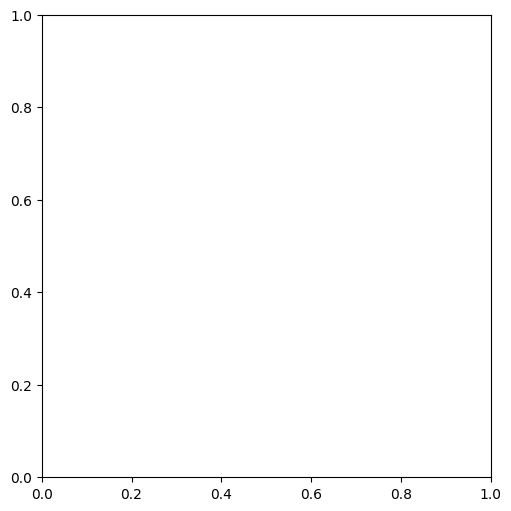

In [11]:
RE(AdPlan.tiggerImg(pimte,0.002),bec)

In [ ]:
RE(AdPlan.tiggerImg(pimtePlan.det,pimtePlan._getTriggerInfo()))

In [ ]:
RE(pimtePlan.takeImg())

In [ ]:
RE(pimtePlan.takeImg(exposure = 0.003, n_img = 3))

In [ ]:
asyncio.create_task(pimte.writer.open())

In [ ]:
asyncio.wait_for(pimte.trigger(), timeout =10)

In [ ]:
asyncio.gather(pimte.writer.close(), pimte.controller.disarm())

In [ ]:
result = asyncio.create_task(test())

In [ ]:
result

In [ ]:
pimte.writer.close